# Integração dos Datasets

## Objetivo do Notebook
Este notebook tem como objetivo integrar os cinco datasets analisados previamente no EDA, criando uma visão consolidada que permita realizar análises cruzadas e identificar padrões relacionados a fraudes em entregas realizadas pelo Walmart na região Central da Flórida. A integração dos dados é um passo fundamental para entender as relações entre motoristas, clientes, produtos e pedidos reportados como problemáticos.
## Datasets Utilizados
#### **Os seguintes datasets serão integrados neste notebook:**
1. `orders`: Contém informações sobre os pedidos, incluindo valores, número de itens entregues e perdidos, horários de entrega, IDs de motoristas e clientes.
2. `missing_data`: Lista produtos declarados como não recebidos pelos clientes.
3. `drivers_data`: Informações sobre os motoristas, como idade e número de entregas realizadas.
4. `products`: Dados sobre os produtos vendidos, incluindo categoria e preço.
5. `customer_data`: Informações sobre os clientes que realizaram as compras.

#### **Passos a Serem Realizados**
1. **Carregamento dos Dados Limpos:**
    * Importar os datasets limpos gerados no notebook de EDA.
    * Verificar a consistência das colunas-chave (keys) que serão utilizadas para a integração.
2. **Integração dos Datasets:**
    * Realizar joins ou merges entre os datasets com base em colunas-chave, como `order_id`, `driver_id`, `product_id`, e `customer_id`.
    * Criar um dataset consolidado que combine informações de pedidos, motoristas, clientes e produtos.
3. **Análises Cruzadas Iniciais:**
    * Explorar padrões nos dados integrados para identificar possíveis fraudes:
    * Motoristas com alta taxa de reclamações.
    * Clientes que frequentemente reportam itens faltantes.
    * Produtos ou categorias mais vulneráveis a problemas de entrega.
## Objetivo Final
O dataset integrado será utilizado como base para análises avançadas e modelagem preditiva nas próximas etapas do projeto. O foco principal é identificar padrões anômalos que possam indicar fraudes atribuídas a motoristas, consumidores ou falhas sistêmicas.


## 1. Carregar dados Limpos

In [1]:
# Importar bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

# Carregar datasets limpos
products = pd.read_csv('products_cleaned.csv')
orders = pd.read_csv('orders_cleaned.csv')
missing_data = pd.read_csv('missing_data_cleaned.csv')
drivers_data = pd.read_csv('drivers_data_cleaned.csv')
customer_data = pd.read_csv('customer_data_cleaned.csv')


### Resumo dos Datasets
#### 1. Products
**Descrição:** Contém informações sobre os produtos vendidos.

**Colunas:**

* `product_id`: Identificador único do produto.
* `product_name`: Nome do produto.
* `category`: Categoria do produto.
* `price`: Preço do produto.
* **Chave Primária:**
    * `product_id` (para combinar com outros datasets, como `missing_data`).

#### 2. Orders
**Descrição:** Contém informações sobre os pedidos realizados.
**Colunas:**
* `order_id`: Identificador único do pedido.
* `order_amount`: Valor total do pedido.
* `region`: Região onde o pedido foi feito.
* `items_delivered`: Número de itens entregues.
* `items_missing`: Número de itens faltantes.
* `delivery_hour`: Hora da entrega.
* `driver_id`: Identificador do motorista que realizou a entrega.
* `customer_id`: Identificador do cliente que fez o pedido.
**Outras colunas:** Taxa de itens faltantes (`missing_rate`), mês (`month_name`), etc.
* **Chaves Primárias:**
    * `order_id` (para combinar com `missing_data`).
    * `driver_id` (para combinar com `drivers_data`).
    * `customer_id` (para combinar com `custom`).

#### 3. Missing Data
**Descrição:** Lista produtos reportados como não entregues pelos clientes.
**Colunas:**
* `order_id`: Identificador único do pedido relacionado aos itens faltantes.
* `product_id_1`, `product_id_2`, `product_id_3`: IDs dos produtos reportados como faltantes (até três produtos por pedido).
* `products_missing`: Lista consolidada de produtos não entregues (em formato de lista).
* `num_products_missing`: Número total de produtos reportados como faltantes no pedido.
* **Chave Primária:**
    * Relaciona-se a outros datasets via `order_id`.
    * Relaciona-se ao dataset de produtos via `product_id`.

#### 4. Drivers Data
**Descrição:** Contém informações sobre os motoristas que realizam as entregas.
**Colunas:**
* `driver_id`: Identificador único do motorista.
* `driver_name`: Nome do motorista.
* `age`: Idade do motorista.
* `Trips`: Número total de viagens realizadas pelo motorista.
* `age_group`: Faixa etária categorizada do motorista.
* **Chave Primária:**
    * Relaciona-se ao dataset de pedidos (`orders`) via `driver_id`.

#### 5. Customer Data
**Descrição:** Contém informações sobre os clientes que realizaram compras.
**Colunas:**
* `customer_id`: Identificador único do cliente.
* `customer_name`: Nome do cliente.
* `customer_age`: Idade do cliente.
* `age_group`: Faixa etária categorizada do cliente.
* **Chave Primária:**
    * Relaciona-se ao dataset de pedidos (`orders`) via `customer_id`.

## 2. Integração dos Datasets (Merging)

### Estrutura de Relacionamento
* `orders` é o dataset central, pois conecta **clientes, motoristas** e **produtos**
* `drivers_data` se relaciona com orders via **driver_id**
* `customer_data` se relaciona com orders via **customer_id**
* `missing_data` está ligado a orders pelo **order_id**, e contem multiplos **product_ids**
* `products` se relaciona com missing_data via **product_id**

#### Consolidar Informações dos Produtos Faltantes
* Lista com nomes dos produtos faltantes.
* Lista com categorias dos produtos faltantes.
* Valor total dos preços dos produtos faltantes.

#### Criar Função para Buscar Detalhes dos Produtos

In [2]:
# Função para buscar detalhes dos produtos
def get_product_details(product_ids, products_df):
    product_names = []
    categories = []
    total_price = 0

    for product_id in product_ids:
        # Buscar detalhes do produto correspondente
        product_info = products_df[products_df['product_id'] == product_id]
        if not product_info.empty:
            product_names.append(product_info['product_name'].values[0])
            categories.append(product_info['category'].values[0])
            total_price += product_info['price'].values[0]
    
    return product_names, categories, total_price


#### Aplicar a Função ao Dataset Missing Data

In [3]:
# Aplicar a função para cada linha do dataset missing_data
missing_data[['product_name', 'category', 'price']] = missing_data['products_missing'].apply(
    lambda x: pd.Series(get_product_details(eval(x), products))
)

### Realizar Integração

#### Unir `orders` com `customer_data`
* Relaciona pedidos com informações dos clientes usando a coluna `customer_id`

In [4]:
df_merged = orders.merge(customer_data, on='customer_id', how='left')

* Usamos `how='left'` para garantir que **todos os pedidos** sejam mantidos, mesmo que falte algum dado do cliente.

#### Unir `orders` com `drivers_data`
* Relaciona pedidos com informações dos motoristas usando a coluna `driver_id`.

In [5]:
df_merged = df_merged.merge(drivers_data, on='driver_id', how='left')

* Usamos `how='left'` para manter **todos os pedidos**, mesmo se faltar info de algum motorista

#### Unir `orders` com `missing_data`
* Relaciona pedidos com informações sobre produtos faltantes usando a coluna `order_id`. Como a coluna `products_missing` já contém uma lista consolidada, podemos integrá-la diretamente.

In [6]:
# Merge entre df_merged e missing_data atualizado
df_final = df_merged.merge(missing_data[['order_id', 'products_missing', 'product_name', 'category', 'price']], 
                           on='order_id', 
                           how='left')


*  `products_missing` já contém **todos os produtos faltantes** com formato de lista
*  Usamos `how='left'` para manter **todos os pedidos**, mesmo os que nao tiveram reclamaçao de produtos faltantes

#### Visualizar o Dataset Integrado

In [7]:
# Verificar a estrutura do DataFrame final
print(df_final.info())
print()
print('Visualizar algumas linhas do DataFrame final')
print()
# Visualizar algumas linhas do DataFrame final
df_final.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              10000 non-null  object 
 1   order_id          10000 non-null  object 
 2   order_amount      10000 non-null  float64
 3   region            10000 non-null  object 
 4   items_delivered   10000 non-null  int64  
 5   items_missing     10000 non-null  int64  
 6   delivery_hour     10000 non-null  object 
 7   driver_id         10000 non-null  object 
 8   customer_id       10000 non-null  object 
 9   missing_rate      10000 non-null  float64
 10  month_name        10000 non-null  object 
 11  items_range       10000 non-null  object 
 12  customer_name     10000 non-null  object 
 13  customer_age      10000 non-null  int64  
 14  age_group_x       10000 non-null  object 
 15  driver_name       10000 non-null  object 
 16  age               10000 non-null  int64  

,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id,missing_rate,...,customer_age,age_group_x,driver_name,age,Trips,age_group_y,products_missing,product_name,category,price
0,2023-01-01,c9da15aa-be24-4871-92a3-dfa7746fff69,1095.54,Winter Park,10,1,08:37:28,WDID10627,WCID5031,0.100000,...,68,66-75,Jeremy Ramos,64,44,56-65,['PWPX0982761091100'],[Apple MacBook Pro],[Electronics],424.82
1,2023-01-01,ccacc183-09f8-4fd5-af35-009d18656326,659.11,Altamonte Springs,11,1,09:31:17,WDID10533,WCID5794,0.090909,...,30,26-35,Michelle Robinson,41,45,36-45,['PWPX0982761091004'],[Instant Noodles],[Supermarket],5.80
2,2023-01-01,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,251.45,Winter Park,18,1,10:43:49,WDID10559,WCID5599,0.055556,...,26,26-35,Thomas White,30,67,26-35,['PWPX0982761091016'],[Romaine Lettuce],[Supermarket],14.22
3,2023-01-01,993d31f4-9358-41f0-a371-0021e55cef5d,598.83,Altamonte Springs,12,1,09:48:33,WDID10622,WCID5005,0.083333,...,85,76-85,Daniel Newman,61,34,56-65,['PWPX0982761091056'],[Salted Butter],[Supermarket],9.89
4,2023-01-01,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925,27.18,Clermont,3,1,10:09:49,WDID10654,WCID5114,0.333333,...,57,56-65,Chris Ryan,51,31,46-55,['PWPX0982761091064'],[Red Onions],[Supermarket],18.81


#### Estrutura Final do Dataset
O dataset `df_final` contem:
* Informações gerais sobre pedidos (`order_id`, `region`, etc..)
* Informações sobre motoristas (`driver_name`, `Trips`, etc.).
* Informações sobre clientes (`customer_name`, `customer_age`, etc.).
* Produtos faltantes como listas consolidadas:
* Lista de IDs dos produtos faltantes (`products_missing`).
* Lista de nomes dos produtos faltantes (`product_name`).
* Lista de categorias dos produtos faltantes (`category`).
* Soma total dos preços dos produtos faltantes (`price`).

In [8]:
# Renomear as colunas age_group_x e age_group_y
df_final = df_final.rename(columns={
    'age_group_x': 'customer_age_group',
    'age_group_y': 'driver_age_group'
})

# Verificar se as colunas foram renomeadas
print(df_final.columns)

Index(['date', 'order_id', 'order_amount', 'region', 'items_delivered',
       'items_missing', 'delivery_hour', 'driver_id', 'customer_id',
       'missing_rate', 'month_name', 'items_range', 'customer_name',
       'customer_age', 'customer_age_group', 'driver_name', 'age', 'Trips',
       'driver_age_group', 'products_missing', 'product_name', 'category',
       'price'],
      dtype='object')


## 3. Análises Cruzadas Iniciais

Agora que os datasets estão integrados, podemos começar a explorar os dados para identificar padrões.


### Explorar Motoristas com Alta Taxa de Reclamações
* Identificar motoristas que frequentemente realizam entregas com itens faltantes.

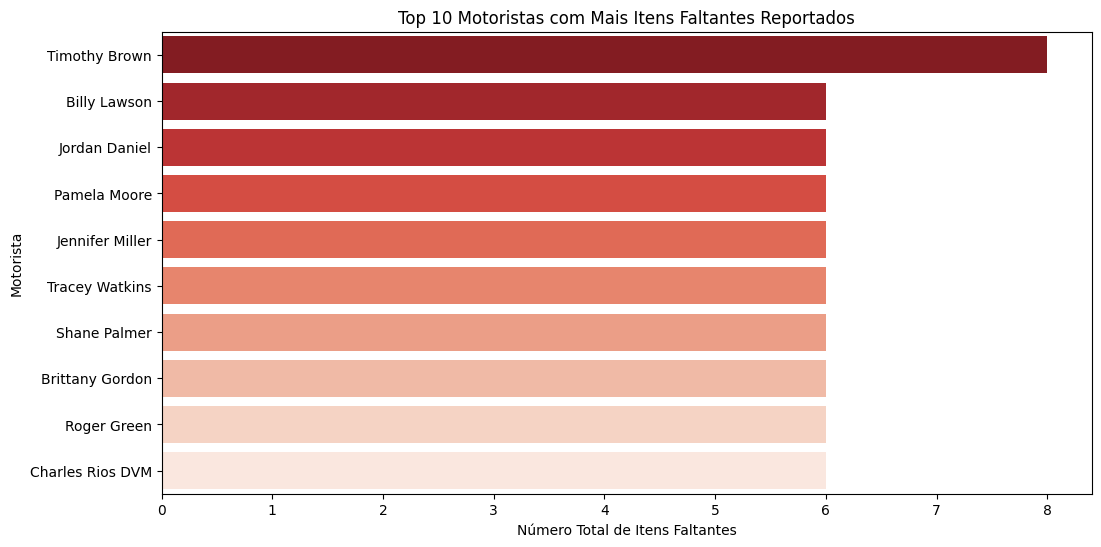

In [69]:
# Contar motoristas com maior número total de reclamações
driver_reincidence = df_final.groupby('driver_name')['items_missing'].sum().sort_values(ascending=False)

# Selecionar os 10 motoristas com maior número de reclamações
top_reincidence_drivers = driver_reincidence.head(10)

# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=top_reincidence_drivers.values, y=top_reincidence_drivers.index, hue=top_reincidence_drivers.index, palette="Reds_r")

# Adicionar títulos e rótulos
plt.xlabel("Número Total de Itens Faltantes")
plt.ylabel("Motorista")
plt.title("Top 10 Motoristas com Mais Itens Faltantes Reportados")
plt.xticks(rotation=0)

# Mostrar o gráfico
plt.show()

In [111]:
# Calcular o número total de entregas, itens perdidos e porcentagem por motorista
driver_analysis = df_final.groupby('driver_name').agg(
    age=('age', 'first'),
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)

# Calcular a porcentagem de itens perdidos
driver_analysis['missing_percentage'] = (driver_analysis['total_missing'] / driver_analysis['total_deliveries']) * 100

# Ordenar os motoristas pela porcentagem de itens perdidos
driver_analysis = driver_analysis.sort_values(by='missing_percentage', ascending=False)

# Selecionar os 10 motoristas com maior porcentagem de itens perdidos
top_drivers = driver_analysis.head(10)
top_drivers

,age,total_deliveries,total_missing,missing_percentage
driver_name,,,,
Brittany Gordon,18,11,6,54.545455
Tracey Watkins,18,11,6,54.545455
Billy Lawson,18,11,6,54.545455
Shane Palmer,18,11,6,54.545455
Stephen Randolph,18,11,6,54.545455
James Winters,18,11,6,54.545455
James White,18,11,6,54.545455
Roger Green,18,11,6,54.545455
Charles Rios DVM,18,11,6,54.545455


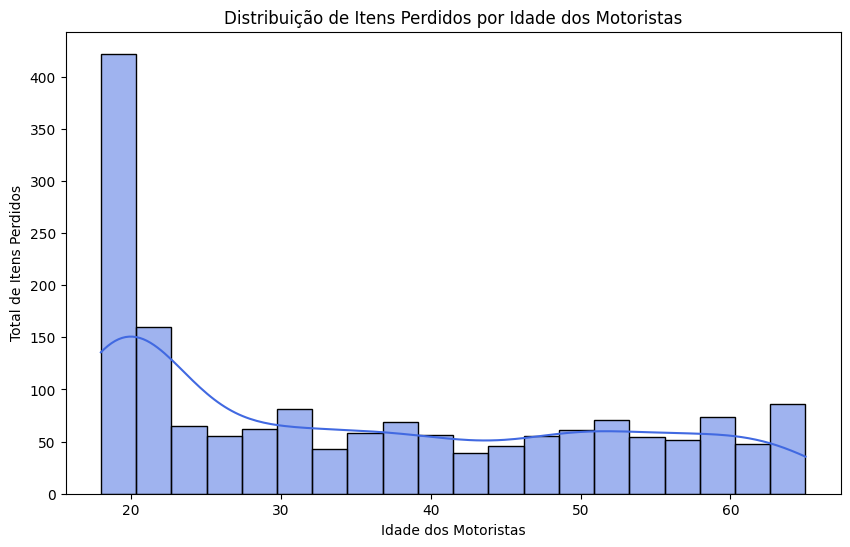

In [80]:
# Criar o histograma para idade dos motoristas com base nos itens perdidos
plt.figure(figsize=(10, 6))
sns.histplot(df_final, x='age', weights='items_missing', bins=20, kde=True, color='royalblue')
plt.title("Distribuição de Itens Perdidos por Idade dos Motoristas")
plt.xlabel("Idade dos Motoristas")
plt.ylabel("Total de Itens Perdidos")
plt.show()

driver_age_group
56-65    0.184922
26-35    0.182482
46-55    0.177374
36-45    0.169479
18-25    0.148701
Name: items_missing, dtype: float64


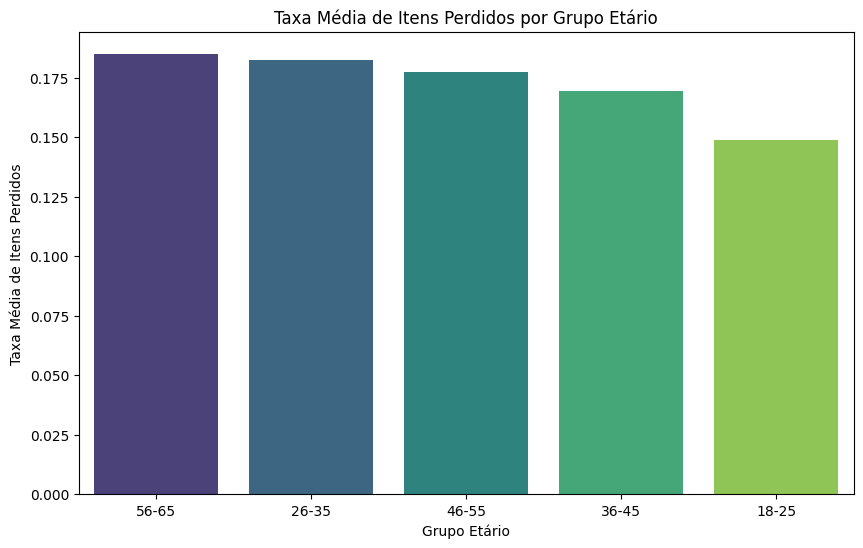

In [11]:
# Calcular a taxa média de itens perdidos por grupo etário
driver_age_group_avg_missing = df_final.groupby('driver_age_group')['items_missing'].mean().sort_values(ascending=False)

# Visualizar os resultados
print(driver_age_group_avg_missing)


# Criar o gráfico de barras para taxa média de itens perdidos por grupo etário
plt.figure(figsize=(10, 6))
sns.barplot(x=driver_age_group_avg_missing.index, y=driver_age_group_avg_missing.values, hue=driver_age_group_avg_missing.index, palette="viridis")
plt.title("Taxa Média de Itens Perdidos por Grupo Etário")
plt.xlabel("Grupo Etário")
plt.ylabel("Taxa Média de Itens Perdidos")
plt.show()


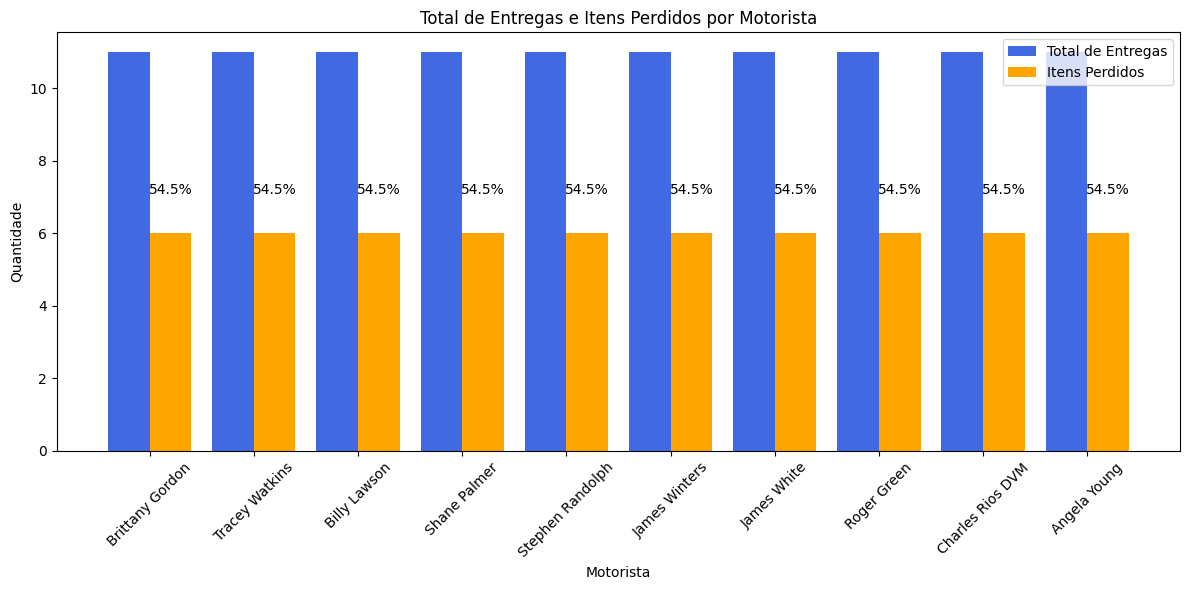

In [109]:
# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Criar as barras separadas para total_deliveries e total_missing
x = range(len(top_drivers))  # Índices para os motoristas
plt.bar(x, top_drivers['total_deliveries'], color='royalblue', width=0.4, label='Total de Entregas')
plt.bar([i + 0.4 for i in x], top_drivers['total_missing'], color='orange', width=0.4, label='Itens Perdidos')

# Adicionar os números da porcentagem acima das barras de itens perdidos
for i, percentage in enumerate(top_drivers['missing_percentage']):
    plt.text(i + 0.4, top_drivers['total_missing'].iloc[i] + 1, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=10)

# Personalizar o gráfico
plt.title("Total de Entregas e Itens Perdidos por Motorista")
plt.xlabel("Motorista")
plt.ylabel("Quantidade")
plt.xticks([i + 0.2 for i in x], top_drivers.index, rotation=45)  # Ajustar os rótulos para ficarem centralizados
plt.legend(loc='upper right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


### Identificar Clientes com Comportamento Suspeito
* Analise de clientes que frequentemente reportam itens faltantes.

In [13]:
# Taxa de reclamação por cliente
customer_complaints = df_final.groupby('customer_name').agg(
    average_missing=('items_missing', 'mean'),
    age=('customer_age', 'first'),
    age_group=('customer_age_group', 'first')  # age_group_x vem do dataset customer_data
).sort_values(by='average_missing', ascending=False)

# Visualizar os 10 clientes com maior taxa de reclamação
top_customers = customer_complaints.head(10)
print(top_customers)


                 average_missing  age age_group
customer_name                                  
Cory Spencer            1.000000   81     76-85
Crystal Smith           1.000000   44     36-45
Joshua Thompson         1.000000   79     76-85
David Mccoy             0.857143   59     56-65
Mark Mcmahon            0.800000   78     76-85
Justin Williams         0.750000   78     76-85
James Vargas            0.750000   78     76-85
Robert Odonnell         0.714286   45     36-45
Julie Reese             0.714286   80     76-85
Ruben Stevenson         0.666667   24     18-25


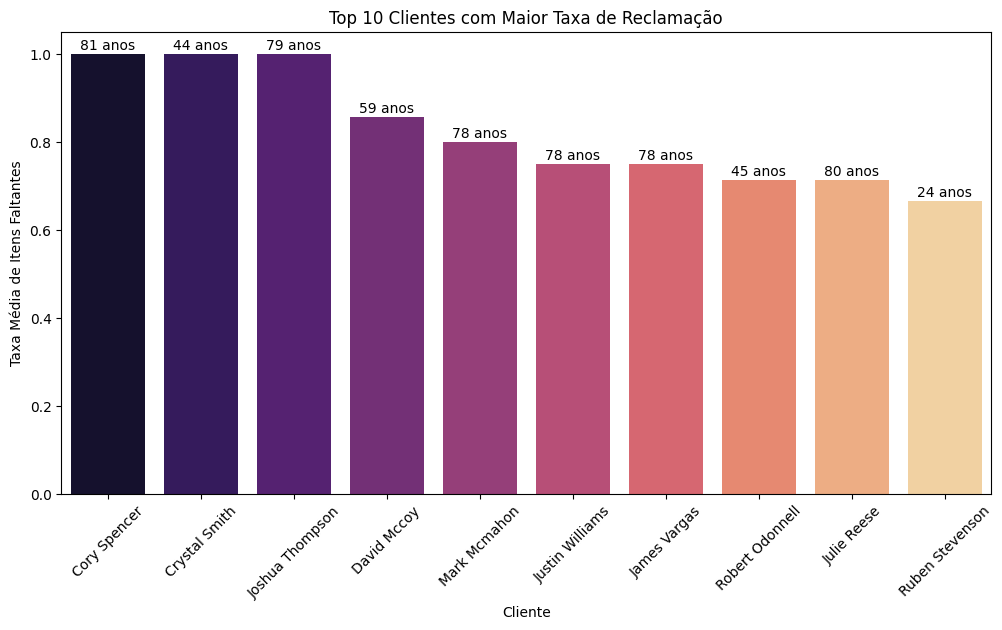

In [15]:
# Criar o gráfico de barras com as idades dos clientes como rótulos
plt.figure(figsize=(12, 6))
sns.barplot(x=top_customers.index, y=top_customers['average_missing'], hue=top_customers.index, palette="magma")
plt.title("Top 10 Clientes com Maior Taxa de Reclamação")
plt.xlabel("Cliente")
plt.ylabel("Taxa Média de Itens Faltantes")
plt.xticks(rotation=45)

# Adicionar as idades como rótulos no topo das barras
for i, (name, row) in enumerate(top_customers.iterrows()):
    plt.text(i, row['average_missing'] + 0.01, f"{row['age']} anos", ha='center', fontsize=10)

plt.show()

In [95]:
# Agrupar os dados por cliente
customer_analysis = df_final.groupby('customer_name').agg(
    total_orders=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)

# Calcular a porcentagem de itens perdidos
customer_analysis['missing_percentage'] = (customer_analysis['total_missing'] / customer_analysis['total_orders']) * 100

# Ordenar os clientes pela porcentagem de itens perdidos
customer_analysis = customer_analysis.sort_values(by='missing_percentage', ascending=False)

# Visualizar os 10 principais clientes com maior porcentagem de itens perdidos
top_customers = customer_analysis.head(10)
print(top_customers)


                 total_orders  total_missing  missing_percentage
customer_name                                                   
Cory Spencer                5              5          100.000000
Crystal Smith               4              4          100.000000
Joshua Thompson             3              3          100.000000
David Mccoy                 7              6           85.714286
Mark Mcmahon                5              4           80.000000
Justin Williams             4              3           75.000000
James Vargas                4              3           75.000000
Robert Odonnell             7              5           71.428571
Julie Reese                 7              5           71.428571
Ruben Stevenson             3              2           66.666667


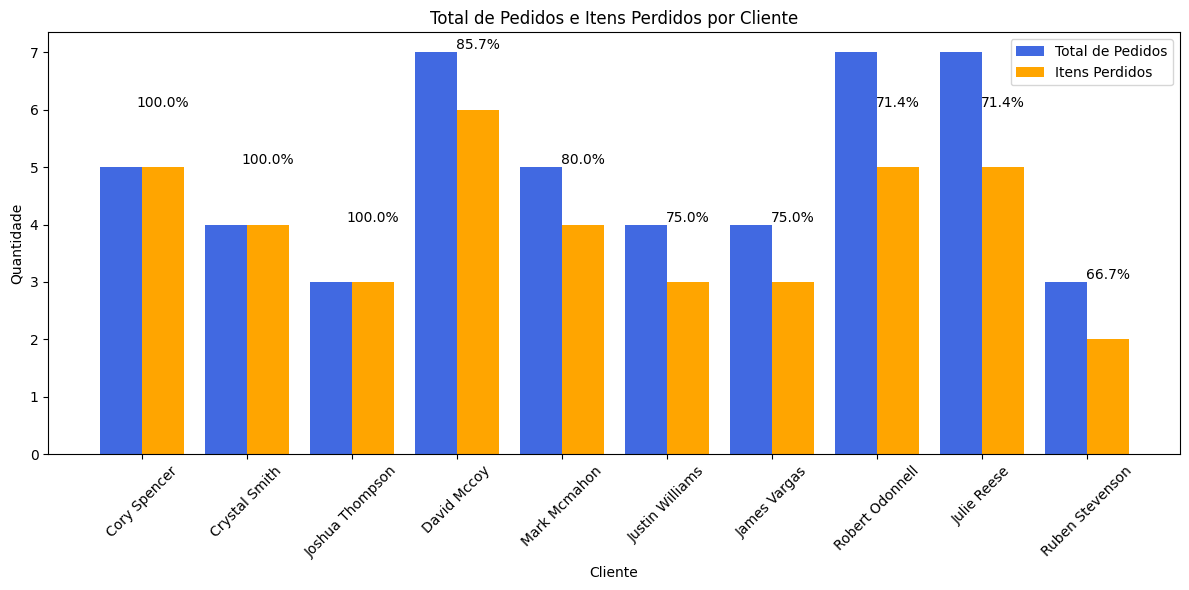

In [102]:
# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Criar as barras separadas para total_orders e total_missing
x = range(len(top_customers))  # Índices para os clientes
plt.bar(x, top_customers['total_orders'], color='royalblue', width=0.4, label='Total de Pedidos')
plt.bar([i + 0.4 for i in x], top_customers['total_missing'], color='orange', width=0.4, label='Itens Perdidos')

# Adicionar os números da porcentagem acima das barras de itens perdidos
for i, percentage in enumerate(top_customers['missing_percentage']):
    plt.text(i + 0.4, top_customers['total_missing'].iloc[i] + 1, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=10)

# Personalizar o gráfico
plt.title("Total de Pedidos e Itens Perdidos por Cliente")
plt.xlabel("Cliente")
plt.ylabel("Quantidade")
plt.xticks([i + 0.2 for i in x], top_customers.index, rotation=45)  # Ajustar os rótulos para ficarem centralizados
plt.legend(loc='upper right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


customer_age_group
36-45    0.175709
76-85    0.174558
85+      0.169643
26-35    0.168135
56-65    0.167669
18-25    0.163470
66-75    0.162690
46-55    0.145414
Name: items_missing, dtype: float64


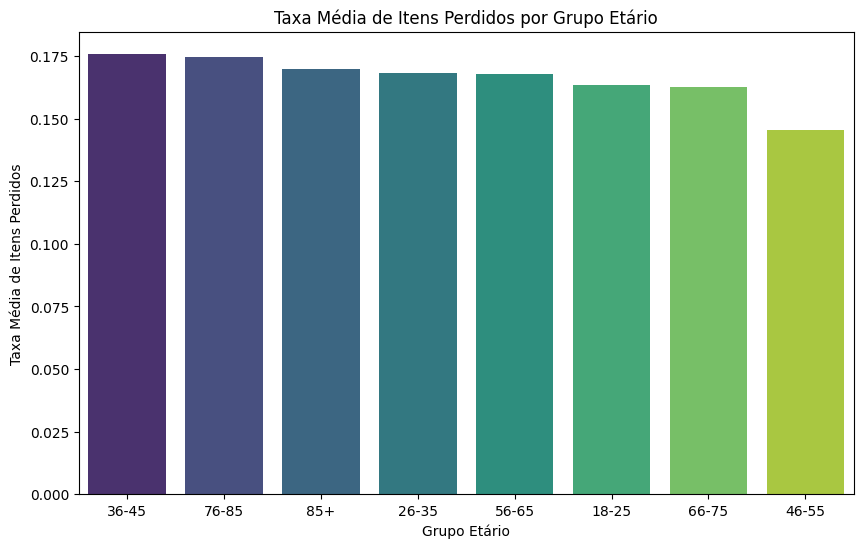

In [17]:
# Calcular a taxa média de itens perdidos por grupo etário
age_group_avg_missing = df_final.groupby('customer_age_group')['items_missing'].mean().sort_values(ascending=False)

# Visualizar os resultados
print(age_group_avg_missing)


# Criar o gráfico de barras para taxa média de itens perdidos por grupo etário
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_avg_missing.index, y=age_group_avg_missing.values, hue=age_group_avg_missing.index, palette="viridis")
plt.title("Taxa Média de Itens Perdidos por Grupo Etário")
plt.xlabel("Grupo Etário")
plt.ylabel("Taxa Média de Itens Perdidos")
plt.show()


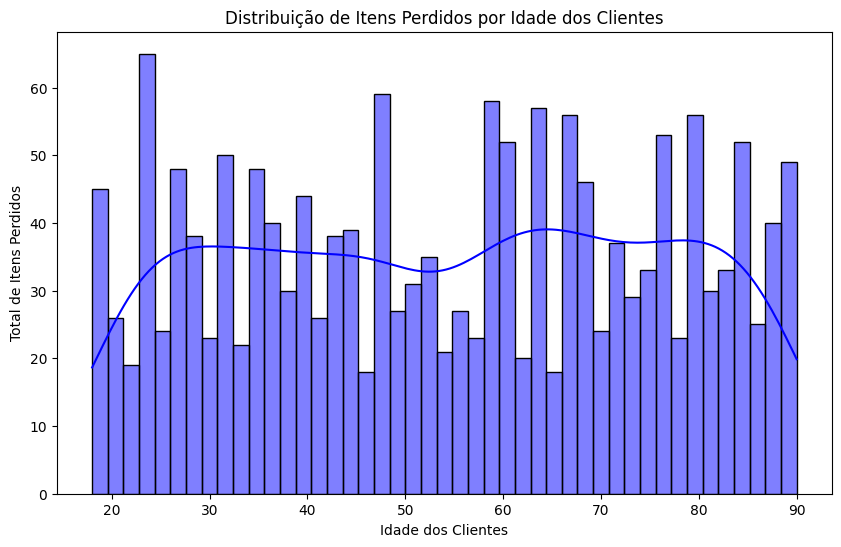

In [81]:
# Criar o histograma para idade dos clientes com base nos itens perdidos
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='customer_age', weights='items_missing', bins=45, kde=True, color='blue')
plt.title("Distribuição de Itens Perdidos por Idade dos Clientes")
plt.xlabel("Idade dos Clientes")
plt.ylabel("Total de Itens Perdidos")
plt.show()


### Analisar Categorias mais Reportadas como Faltantes
* Identificar frequencia de itens faltantes por categoria

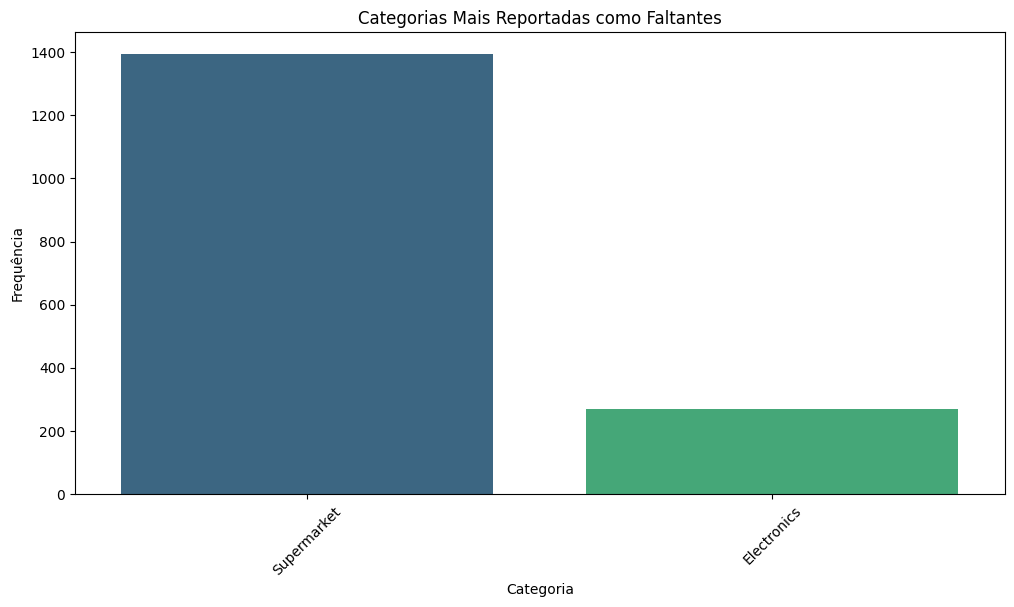

In [82]:
# Contar categorias mais reportadas como faltantes
all_categories = [item for sublist in df_final['category'].dropna() for item in sublist]
category_counts = Counter(all_categories)

# Transformar o resultado em DataFrames para visualização
category_df = pd.DataFrame(category_counts.most_common(10), columns=['Categoria', 'Frequência'])

# Criar o gráfico de barras para categorias
plt.figure(figsize=(12, 6))
sns.barplot(x='Categoria', y='Frequência', data=category_df, hue='Categoria', palette="viridis")
plt.title("Categorias Mais Reportadas como Faltantes")
plt.xlabel("Categoria")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.show()

### Analisar Produtos Mais Reportados como Faltantes
* Identificar produtos que aparecem frequentemente em pedidos com problemas.

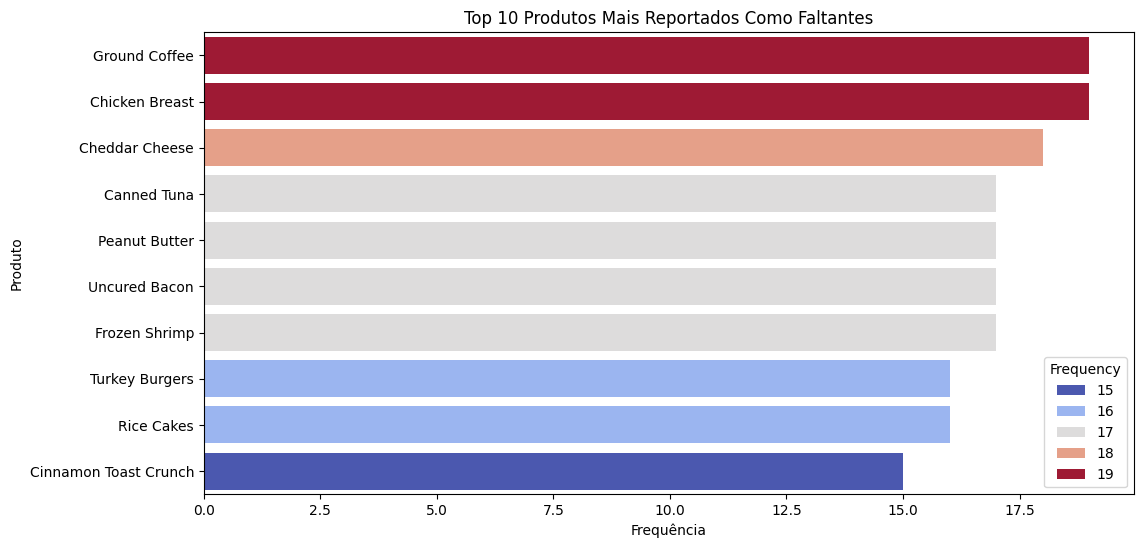

In [84]:
# Plotar gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=product_df['Frequency'][:10], y=product_df['Product'][:10], hue=product_df['Frequency'][:10], palette="coolwarm")
plt.xlabel('Frequência')
plt.ylabel('Produto')
plt.title('Top 10 Produtos Mais Reportados Como Faltantes')

plt.show()

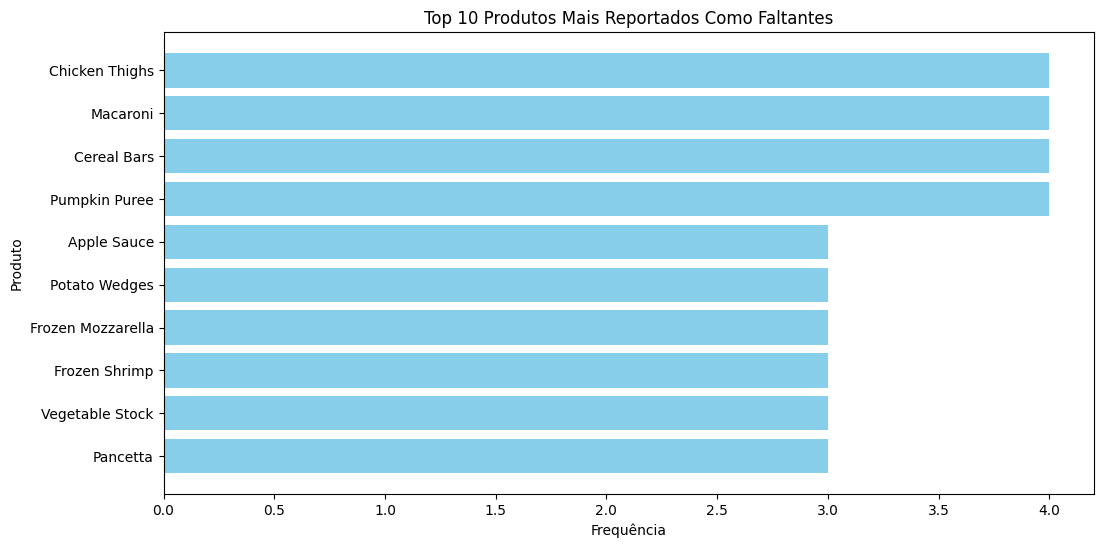

In [33]:
# Criar uma lista com todos os produtos faltantes (unificando os pares)
all_missing_products = [product for pair in product_combinations for product in pair]

# Contar a frequência de cada produto
product_counts = Counter(all_missing_products)

# Criar um DataFrame para visualização
missing_df = pd.DataFrame(product_counts.items(), columns=['Product', 'Frequency'])
missing_df = missing_df.sort_values(by='Frequency', ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(missing_df['Product'][:10], missing_df['Frequency'][:10], color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Produto')
plt.title('Top 10 Produtos Mais Reportados Como Faltantes')
plt.gca().invert_yaxis()  # Inverter para o mais frequente aparecer no topo
plt.show()

In [32]:
# Criar um dicionário para mapear product_id -> product_name
product_id_to_name = dict(zip(products['product_id'], products['product_name']))

# Substituir NaN por listas vazias
df_final['products_missing'] = df_final['products_missing'].apply(
    lambda x: eval(x) if isinstance(x, str) else x  # Converte strings para listas
)
df_final['products_missing'] = df_final['products_missing'].apply(
    lambda x: x if isinstance(x, list) else []  # Garante que todos os valores são listas
)

# Substituir os IDs pelos nomes dos produtos
df_final['products_missing'] = df_final['products_missing'].apply(
    lambda product_list: [product_id_to_name.get(pid, "Desconhecido") for pid in product_list]
)

# Criar uma lista para armazenar todas as combinações de produtos faltantes
product_combinations = []

for products in df_final['products_missing']:
    product_combinations.extend(combinations(sorted(set(products)), 2))

# Contar a frequência de cada par de produtos
co_occurrence_counts = Counter(product_combinations)

# Criar um DataFrame com os resultados
co_occurrence_df = pd.DataFrame(co_occurrence_counts.items(), columns=['Product Pair', 'Frequency'])

# Ordenar os pares mais frequentes
co_occurrence_df = co_occurrence_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Exibir os 10 pares mais comuns de produtos faltantes
print(co_occurrence_df.head(10))

                                 Product Pair  Frequency
0                         (Chia Seeds, Ramen)          1
1            (Bagged Spinach, Frozen Waffles)          1
2                (Apple iPad Air, Red Grapes)          1
3                 (Hot Dog Buns, Maple Syrup)          1
4          (Shredded Carrots, Sweet Potatoes)          1
5                   (Pancake Mix, Rice Cakes)          1
6  (Beats Studio Pro Headphone, Oyster Sauce)          1
7         (Frozen Shrimp, Sony PlayStation 5)          1
8               (Protein Bars, Whipped Cream)          1
9                 (Pumpkin Puree, Red Onions)          1


### Analise Regional ou Horarios Criticos
* Explorar padrões regionais e horários associados a entregas problemáticas

In [20]:
# Converter delivery_hour para datetime
df_final['delivery_hour'] = pd.to_datetime(df_final['delivery_hour'], format='%H:%M:%S').dt.time

# Função para categorizar os horários
def categorize_delivery_period(hour):
    if hour >= pd.to_datetime('06:00:00', format='%H:%M:%S').time() and hour < pd.to_datetime('12:00:00', format='%H:%M:%S').time():
        return 'Manhã'
    elif hour >= pd.to_datetime('12:00:00', format='%H:%M:%S').time() and hour < pd.to_datetime('18:00:00', format='%H:%M:%S').time():
        return 'Tarde'
    else:
        return 'Noite'

# Aplicar a função para criar a nova coluna
df_final['delivery_period'] = df_final['delivery_hour'].apply(categorize_delivery_period)

# Visualizar as primeiras linhas
df_final[['delivery_hour', 'delivery_period']].head()


,delivery_hour,delivery_period
0,08:37:28,Manhã
1,09:31:17,Manhã
2,10:43:49,Manhã
3,09:48:33,Manhã
4,10:09:49,Manhã


In [21]:
# Contar o número total de entregas e calcular a soma dos itens faltantes por período
period_summary = df_final.groupby('delivery_period').agg(
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)

# Calcular a taxa média de reclamações por entrega
period_summary['average_missing_rate'] = period_summary['total_missing'] / period_summary['total_deliveries']

# Ordenar os resultados pelo número total de entregas
period_summary = period_summary.sort_values(by='total_deliveries', ascending=False)

# Visualizar os resultados
period_summary


,total_deliveries,total_missing,average_missing_rate
delivery_period,,,
Noite,4993,813,0.162828
Tarde,2526,404,0.159937
Manhã,2481,440,0.177348


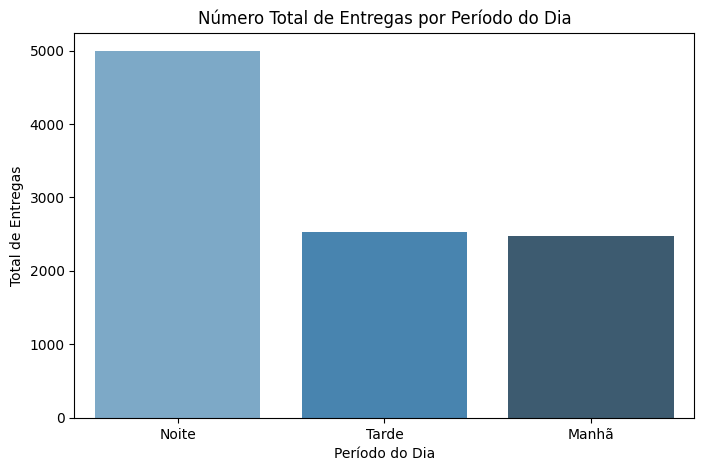

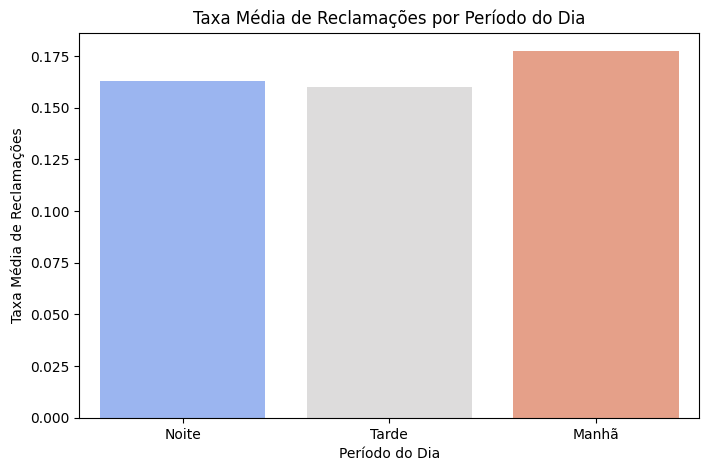

In [22]:
# Gráfico 1: Número total de entregas por período
plt.figure(figsize=(8, 5))
sns.barplot(x=period_summary.index, y=period_summary['total_deliveries'], hue=period_summary.index,  palette="Blues_d")
plt.title("Número Total de Entregas por Período do Dia")
plt.xlabel("Período do Dia")
plt.ylabel("Total de Entregas")
plt.show()

# Gráfico 2: Taxa média de reclamações por entrega
plt.figure(figsize=(8, 5))
sns.barplot(x=period_summary.index, y=period_summary['average_missing_rate'], hue=period_summary.index, palette="coolwarm")
plt.title("Taxa Média de Reclamações por Período do Dia")
plt.xlabel("Período do Dia")
plt.ylabel("Taxa Média de Reclamações")
plt.show()

In [23]:
region_period_summary = df_final.groupby(['region', 'delivery_period']).agg(
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)
region_period_summary['average_missing_rate'] = region_period_summary['total_missing'] / region_period_summary['total_deliveries']
region_period_summary = region_period_summary.reset_index()

region_period_summary.head()

,region,delivery_period,total_deliveries,total_missing,average_missing_rate
0,Altamonte Springs,Manhã,358,65,0.181564
1,Altamonte Springs,Noite,718,124,0.172702
2,Altamonte Springs,Tarde,350,64,0.182857
3,Apopka,Manhã,347,62,0.178674
4,Apopka,Noite,723,137,0.189488


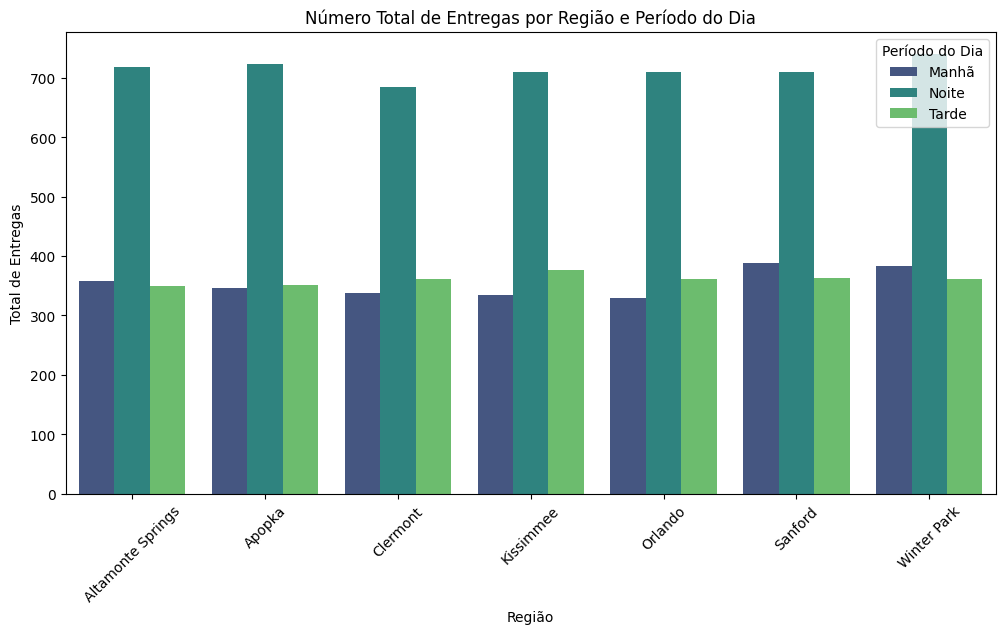

In [24]:
# Criar o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))
sns.barplot(
    data=region_period_summary,
    x='region',
    y='total_deliveries',
    hue='delivery_period',
    palette="viridis"
)
plt.title("Número Total de Entregas por Região e Período do Dia")
plt.xlabel("Região")
plt.ylabel("Total de Entregas")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()

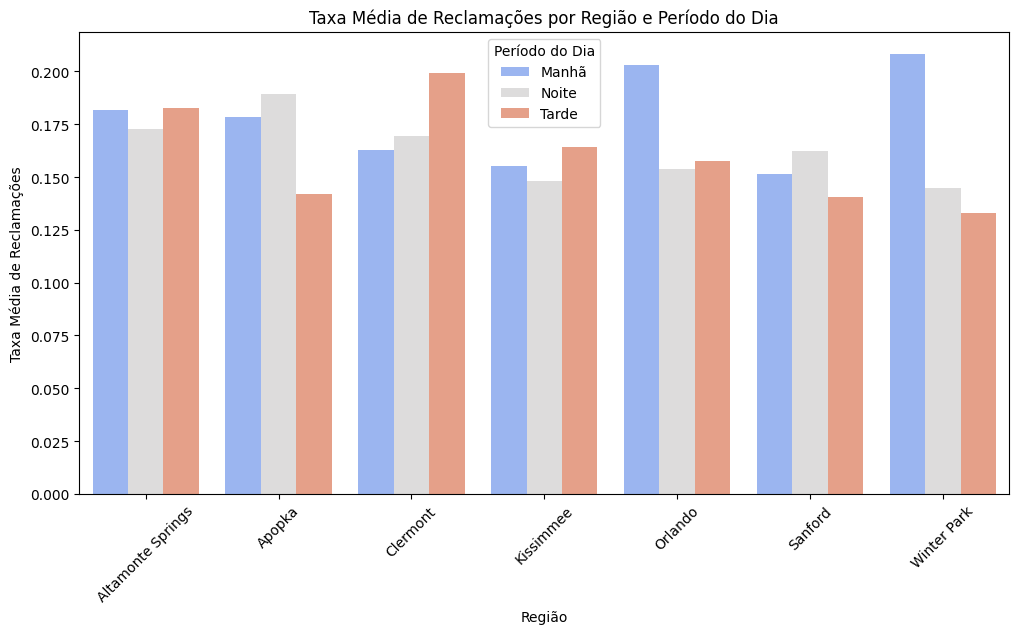

In [25]:
# Criar o gráfico de barras empilhadas para a taxa média de reclamações
plt.figure(figsize=(12, 6))
sns.barplot(
    data=region_period_summary,
    x='region',
    y='average_missing_rate',
    hue='delivery_period',
    palette="coolwarm"
)
plt.title("Taxa Média de Reclamações por Região e Período do Dia")
plt.xlabel("Região")
plt.ylabel("Taxa Média de Reclamações")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()


In [26]:
# Agrupar dados por motorista e período do dia
driver_period_summary = df_final.groupby(['driver_name', 'delivery_period']).agg(
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)
driver_period_summary['average_missing_rate'] = driver_period_summary['total_missing'] / driver_period_summary['total_deliveries']
driver_period_summary = driver_period_summary.reset_index()

# Visualizar os resultados
driver_period_summary.head()


,driver_name,delivery_period,total_deliveries,total_missing,average_missing_rate
0,Aaron Garcia,Manhã,3,2,0.666667
1,Aaron Garcia,Noite,5,2,0.400000
2,Aaron Garcia,Tarde,3,0,0.000000
3,Aaron Jackson,Manhã,3,0,0.000000
4,Aaron Jackson,Noite,3,0,0.000000


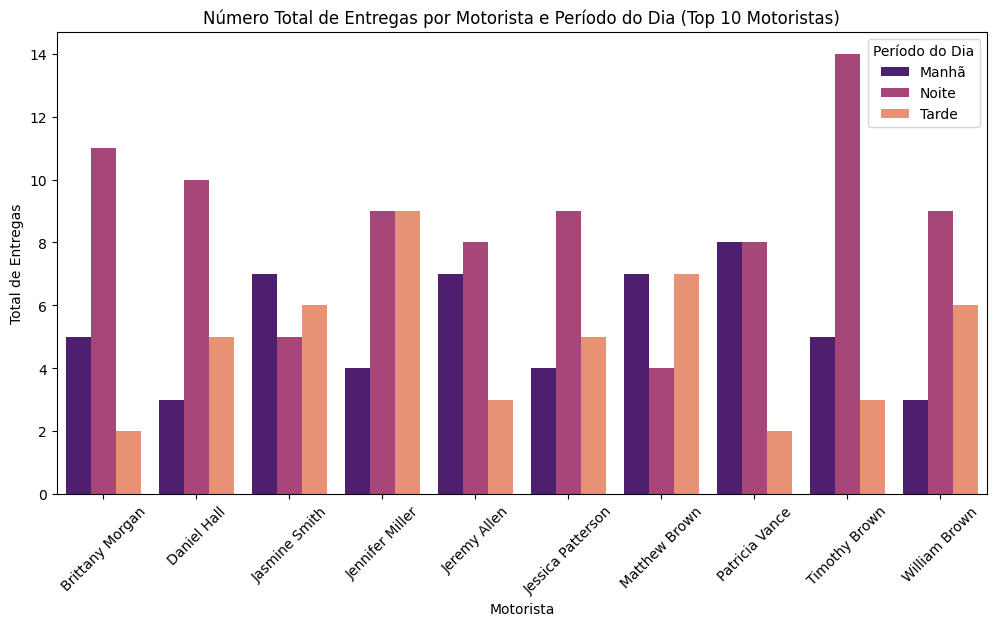

In [27]:
# Filtrar os 10 motoristas com mais entregas para visualização
top_drivers = driver_period_summary.groupby('driver_name')['total_deliveries'].sum().nlargest(10).index
filtered_driver_data = driver_period_summary[driver_period_summary['driver_name'].isin(top_drivers)]

# Criar o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_driver_data,
    x='driver_name',
    y='total_deliveries',
    hue='delivery_period',
    palette="magma"
)
plt.title("Número Total de Entregas por Motorista e Período do Dia (Top 10 Motoristas)")
plt.xlabel("Motorista")
plt.ylabel("Total de Entregas")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()


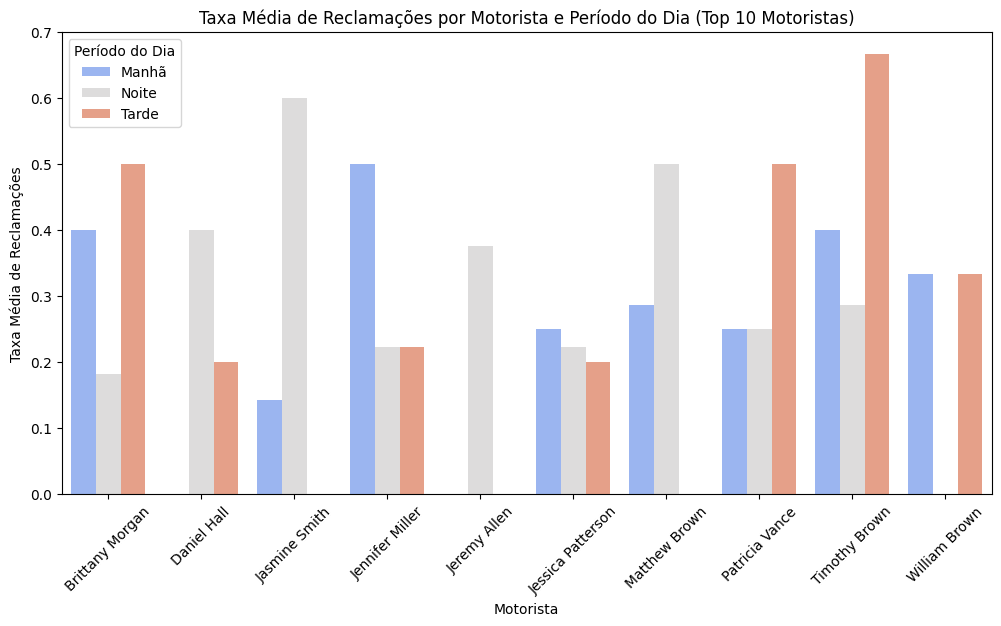

In [28]:
# Criar o gráfico de barras empilhadas para a taxa média de reclamações (Top 10 Motoristas)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_driver_data,
    x='driver_name',
    y='average_missing_rate',
    hue='delivery_period',
    palette="coolwarm"
)
plt.title("Taxa Média de Reclamações por Motorista e Período do Dia (Top 10 Motoristas)")
plt.xlabel("Motorista")
plt.ylabel("Taxa Média de Reclamações")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()


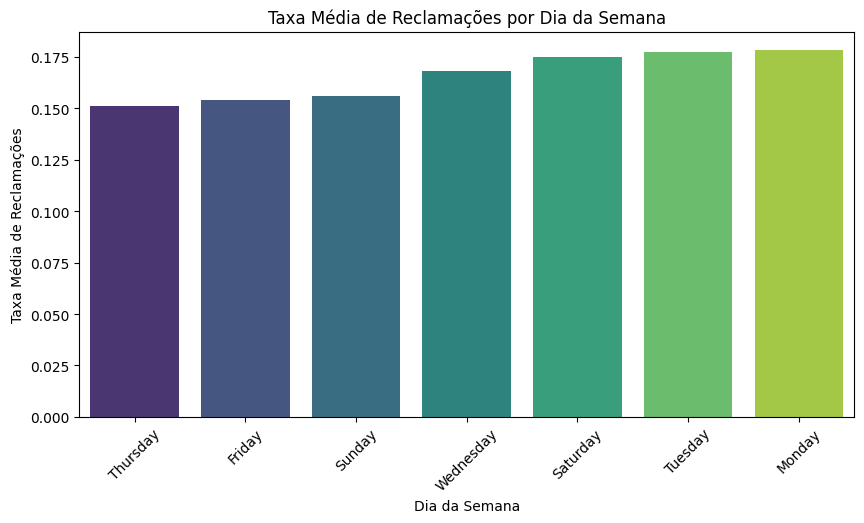

day_of_week
Thursday     0.151406
Friday       0.154167
Sunday       0.156019
Wednesday    0.168079
Saturday     0.174797
Tuesday      0.177465
Monday       0.178311
Name: items_missing, dtype: float64

In [37]:
# Taxa média de reclamações por dia da semana
df_final['day_of_week'] = pd.to_datetime(df_final['date']).dt.day_name()
day_of_week_complaints = df_final.groupby('day_of_week')['items_missing'].mean().sort_values()

# Gráfico para taxa média de reclamações por dia da semana
plt.figure(figsize=(10, 5))
sns.barplot(x=day_of_week_complaints.index, y=day_of_week_complaints.values, hue=day_of_week_complaints.index, palette="viridis")
plt.title("Taxa Média de Reclamações por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Taxa Média de Reclamações")
plt.xticks(rotation=45)
plt.show()

day_of_week_complaints

## Pedidos

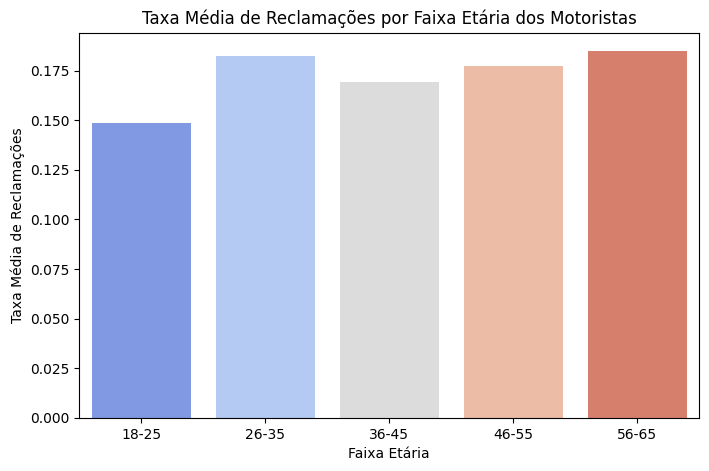

Taxa media de Reclamações por motoristas driver_age_group
18-25    0.148701
26-35    0.182482
36-45    0.169479
46-55    0.177374
56-65    0.184922
Name: items_missing, dtype: float64


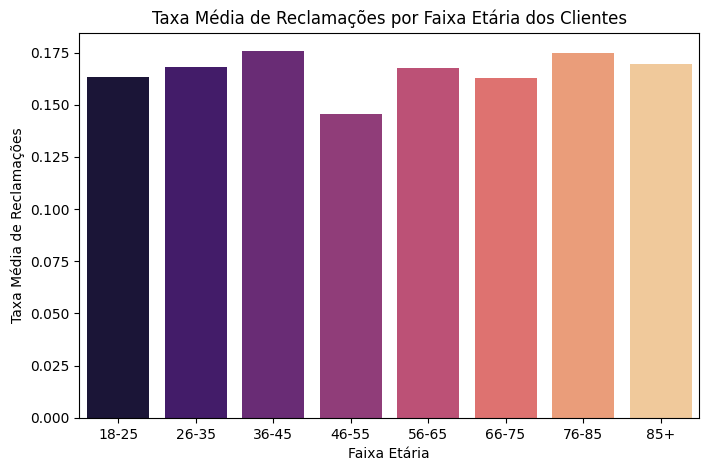

Taxa media de Reclamações por clientes customer_age_group
18-25    0.163470
26-35    0.168135
36-45    0.175709
46-55    0.145414
56-65    0.167669
66-75    0.162690
76-85    0.174558
85+      0.169643
Name: items_missing, dtype: float64


In [31]:
# Taxa média de reclamações por faixa etária dos motoristas
driver_age_complaints = df_final.groupby('driver_age_group')['items_missing'].mean()

# Taxa média de reclamações por faixa etária dos clientes
customer_age_complaints = df_final.groupby('customer_age_group')['items_missing'].mean()

# Gráfico para motoristas
plt.figure(figsize=(8, 5))
sns.barplot(x=driver_age_complaints.index, y=driver_age_complaints.values, hue=driver_age_complaints.index, palette="coolwarm")
plt.title("Taxa Média de Reclamações por Faixa Etária dos Motoristas")
plt.xlabel("Faixa Etária")
plt.ylabel("Taxa Média de Reclamações")
plt.show()

print("Taxa media de Reclamações por motoristas", driver_age_complaints)

# Gráfico para clientes
plt.figure(figsize=(8, 5))
sns.barplot(x=customer_age_complaints.index, y=customer_age_complaints.values, hue=customer_age_complaints.index, palette="magma")
plt.title("Taxa Média de Reclamações por Faixa Etária dos Clientes")
plt.xlabel("Faixa Etária")
plt.ylabel("Taxa Média de Reclamações")
plt.show()

print("Taxa media de Reclamações por clientes", customer_age_complaints)


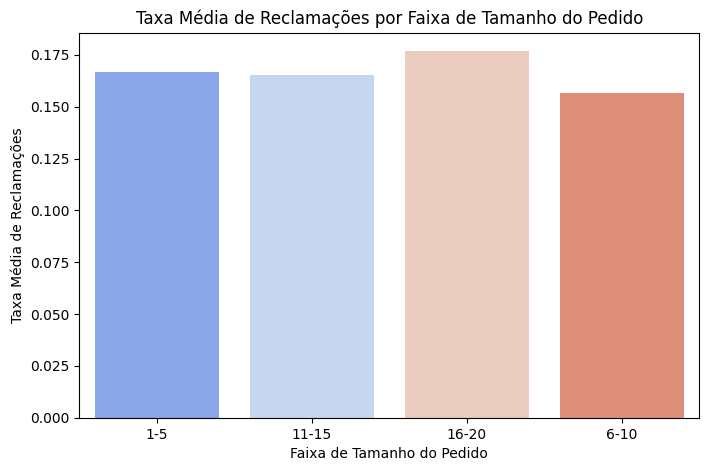

items_range
1-5      0.166667
11-15    0.165289
16-20    0.176812
6-10     0.156416
Name: items_missing, dtype: float64

In [38]:
# Taxa média de reclamações por faixa de tamanho do pedido
size_range_complaints = df_final.groupby('items_range')['items_missing'].mean()

# Gráfico para taxa média de reclamações por faixa de tamanho do pedido
plt.figure(figsize=(8, 5))
sns.barplot(x=size_range_complaints.index, y=size_range_complaints.values, hue=size_range_complaints.index, palette="coolwarm")
plt.title("Taxa Média de Reclamações por Faixa de Tamanho do Pedido")
plt.xlabel("Faixa de Tamanho do Pedido")
plt.ylabel("Taxa Média de Reclamações")
plt.show()

size_range_complaints


In [34]:
# Contar quantos pedidos tinham mais de um produto faltando
num_pedidos_multiplos = (df_final['products_missing'].apply(len) > 1).sum()
total_pedidos = len(df_final)

print(f"Total de pedidos: {total_pedidos}")
print(f"Pedidos com mais de um produto faltante: {num_pedidos_multiplos} ({(num_pedidos_multiplos/total_pedidos)*100:.2f}%)")

Total de pedidos: 10000
Pedidos com mais de um produto faltante: 143 (1.43%)


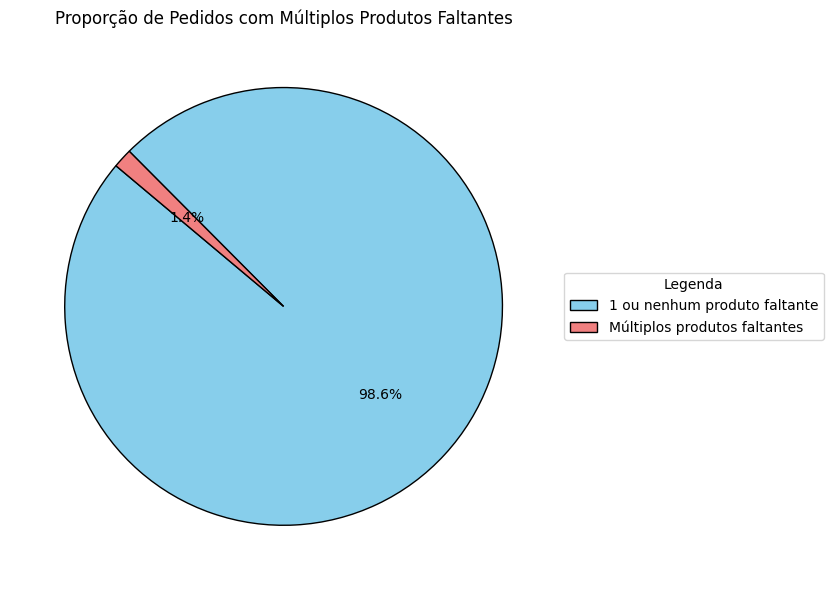

In [94]:
# Definir os dados para o gráfico
sizes = [total_pedidos - num_pedidos_multiplos, num_pedidos_multiplos]
labels = ['1 ou nenhum produto faltante', 'Múltiplos produtos faltantes']
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(8, 6))
wedges, _, autotexts = plt.pie(
    sizes, autopct='%1.1f%%', colors=colors, 
    startangle=140, wedgeprops={'edgecolor': 'black'}
)

# Adicionar legenda ao lado do gráfico
plt.legend(wedges, labels, title="Legenda", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

# Adicionar título
plt.title("Proporção de Pedidos com Múltiplos Produtos Faltantes")

# Ajustar layout para evitar cortes
plt.tight_layout()

# Mostrar o gráfico
plt.show()